In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import gc
import keras
from keras import backend as K
from keras.utils import plot_model
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

C:\Users\frodo\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\frodo\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\frodo\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\frodo\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\pyth

In [2]:
tf.__version__

'1.12.0'

In [3]:
keras.__version__

'2.1.6'

# Load and Preprocessing the CIFAR10 Dataset

In [4]:
# Create label and digit map
digit2labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
                5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
label2digits = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 
                'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [5]:
# Download the CIFAR10 dataset from Kaggle: https://www.kaggle.com/c/cifar-10
# Unzip the download data train.7z and test.7z such that 
# training images is in ./data/train/ and test images are in ./data/test/

preprocessing = False  # whether or not to read the images and save to numpy array
if preprocessing is True:
    train_label = pd.read_csv('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/trainLabels.csv')['label'].values
    test_label = pd.read_csv('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/sampleSubmission.csv')
    
    # process the training set, totally 50,000 images
    train_x = []
    train_y = []
    num = 50000
    for i in range(num):
        img = imread('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/train/train/{0:d}.png'.format(i + 1))
        label = train_label[i]
        train_x.append(img)
        train_y.append(label)
        
    # process the test set, totally 300,000 images
    test_x = []
    num = 300000
    for i in range(num):
        img = imread('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/test/test/{0:d}.png'.format(i + 1))
        test_x.append(img)
        
    # Transform to numpy array
    train_x = np.array(train_x, dtype='uint8')
    train_y = np.array(list(map(lambda x: label2digits[x], train_y))).reshape((-1, 1))
    test_x = np.array(test_x, dtype='uint8')

    # Save to disk
    np.save('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/data/train_x.npy', train_x)
    np.save('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/data/train_y.npy', train_y)
    np.save('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/data/test_x.npy', test_x)

In [6]:
# Load CIFAR10 dataset instead of using the data from Kaggle
(train_x, train_y), (val_x, val_y) = cifar10.load_data()

# Read test images
test_x = np.load('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/data/test_x.npy')

# Transform data format
train_x = train_x.astype('float32') / 255
val_x = val_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

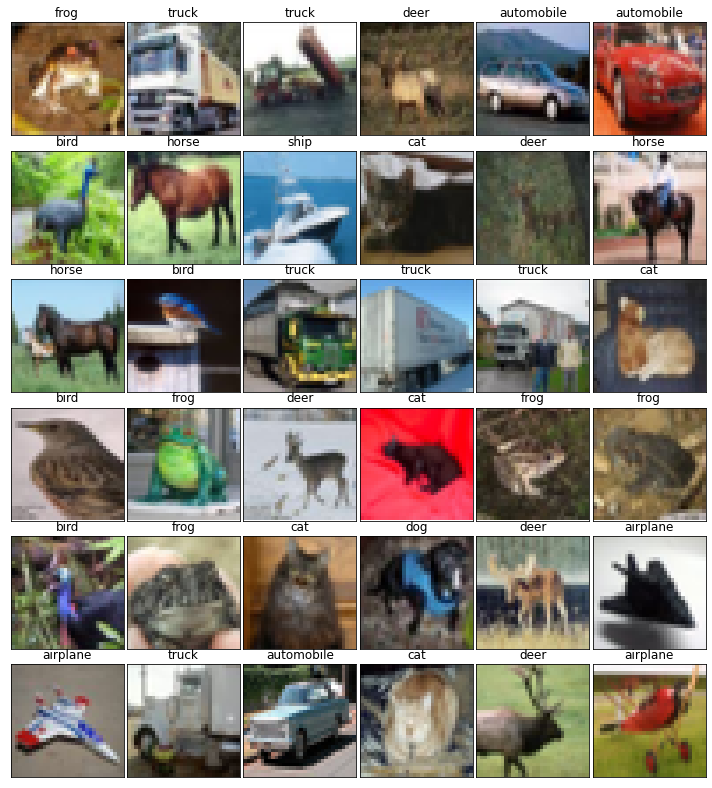

In [7]:
# Visualize the CIFAR10 dataset
nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 11))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax[row][col].imshow(train_x[idx])
        ax[row][col].set_title(digit2labels[train_y[idx][0]])
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
plt.tight_layout(h_pad=0, w_pad=0)
fig.savefig('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/result/snapshot.png', dpi=200)
plt.show()

In [8]:
# Subtrack pixel mean
train_x_mean = np.mean(train_x, axis=0)
train_x -= train_x_mean
val_x -= train_x_mean
test_x -= train_x_mean

# Convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 10)
val_y = keras.utils.to_categorical(val_y, 10)

# Get the info about the dataset
print('Train:\t\t', train_x.shape, val_y.shape)
print('Valdation:\t', val_x.shape, val_y.shape)
print('Test:\t\t', test_x.shape)

Train:		 (50000, 32, 32, 3) (10000, 10)
Valdation:	 (10000, 32, 32, 3) (10000, 10)
Test:		 (300000, 32, 32, 3)


# Build VGG Model

VGG is a easy-to-understand CNN model built for ImageNet recognition. Here, the model is built based on the original paper

In [9]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def vgg(input_shape=(32, 32, 3), classes=10):
    """ Define VGG model using Keras API """
    model = Sequential(name='VGG')
    # Block # 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv1'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block1_pool'))
    model.add(Dropout(rate=0.25, name='block1_dropout'))
    
    # Block # 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block2_pool'))
    model.add(Dropout(rate=0.3, name='block2_dropout'))
    
    # Block # 3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block3_pool'))
    model.add(Dropout(rate=0.35, name='block3_dropout'))
    
    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=256, activation='relu', name='fc1'))
    model.add(Dropout(rate=0.5, name='fc1_dropout'))
    model.add(Dense(units=128, activation='relu', name='fc2'))
    model.add(Dropout(rate=0.5, name='fc2_dropout'))
    model.add(Dense(units=classes, activation='softmax', name='prediction'))
    
    return model

In [10]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# tf.random.set_seed(42)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [11]:
# Create VGG model
input_shape = (32, 32, 3)
vgg_model = vgg(input_shape=input_shape, classes=10)

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [12]:
# Create optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/models/vgg_checkpoint.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Real-time data augumentation
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0.0,
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

# Fit generator on training set
datagen.fit(train_x)

# Fit the model on the batches
vgg_history = vgg_model.fit_generator(datagen.flow(train_x, train_y, batch_size=128),
                                      validation_data=(val_x, val_y), epochs=200, 
                                      verbose=2, workers=4, callbacks=callbacks)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
 - 74s - loss: 1.8669 - acc: 0.2874 - val_loss: 1.4716 - val_acc: 0.4551
Epoch 2/200
Learning rate:  0.001
 - 70s - loss: 1.4950 - acc: 0.4499 - val_loss: 1.3551 - val_acc: 0.5062
Epoch 3/200
Learning rate:  0.001
 - 74s - loss: 1.3255 - acc: 0.5230 - val_loss: 1.1110 - val_acc: 0.6042
Epoch 4/200
Learning rate:  0.001
 - 77s - loss: 1.2235 - acc: 0.5678 - val_loss: 1.0087 - val_acc: 0.6400
Epoch 5/200
Learning rate:  0.001
 - 77s - loss: 1.1398 - acc: 0.6003 - val_loss: 0.9568 - val_acc: 0.6547
Epoch 6/200
Learning rate:  0.001
 - 80s - loss: 1.0785 - acc: 0.6248 - val_loss: 0.8748 - val_acc: 0.6895
Epoch 7/200
Learning rate:  0.001
 - 81s - loss: 1.0287 - acc: 0.6423 - val_loss: 0.9398 - val_acc: 0.6654
Epoch 8/200
Learning rate:  0.001
 - 81s - loss: 0.9911 - acc: 0.6582 - val_loss: 0.8269 - val_acc: 0.7037
Epoch 9/200
Learning rate:  0.001
 - 81s - loss: 0.9497 - acc: 0.6739 - val_loss: 0.8505 - val_acc: 0.6996
Epoch 10/200
Le

Epoch 77/200
Learning rate:  0.001
 - 97s - loss: 0.6104 - acc: 0.8007 - val_loss: 0.5584 - val_acc: 0.8179
Epoch 78/200
Learning rate:  0.001
 - 125s - loss: 0.6088 - acc: 0.8020 - val_loss: 0.5202 - val_acc: 0.8294
Epoch 79/200
Learning rate:  0.001
 - 103s - loss: 0.6067 - acc: 0.8027 - val_loss: 0.5582 - val_acc: 0.8165
Epoch 80/200
Learning rate:  0.001
 - 105s - loss: 0.5974 - acc: 0.8042 - val_loss: 0.5690 - val_acc: 0.8129
Epoch 81/200
Learning rate:  0.001
 - 162s - loss: 0.6068 - acc: 0.8026 - val_loss: 0.5898 - val_acc: 0.8078
Epoch 82/200
Learning rate:  0.0001
 - 130s - loss: 0.5577 - acc: 0.8195 - val_loss: 0.5091 - val_acc: 0.8313
Epoch 83/200
Learning rate:  0.0001
 - 103s - loss: 0.5356 - acc: 0.8255 - val_loss: 0.5050 - val_acc: 0.8318
Epoch 84/200
Learning rate:  0.0001
 - 107s - loss: 0.5335 - acc: 0.8265 - val_loss: 0.4965 - val_acc: 0.8366
Epoch 85/200
Learning rate:  0.0001
 - 161s - loss: 0.5268 - acc: 0.8282 - val_loss: 0.5016 - val_acc: 0.8356
Epoch 86/200
Lea

Epoch 152/200
Learning rate:  1e-05
 - 99s - loss: 0.4642 - acc: 0.8473 - val_loss: 0.4722 - val_acc: 0.8458
Epoch 153/200
Learning rate:  1e-05
 - 99s - loss: 0.4686 - acc: 0.8463 - val_loss: 0.4736 - val_acc: 0.8449
Epoch 154/200
Learning rate:  1e-05
 - 99s - loss: 0.4711 - acc: 0.8430 - val_loss: 0.4719 - val_acc: 0.8460
Epoch 155/200
Learning rate:  1e-05
 - 99s - loss: 0.4724 - acc: 0.8429 - val_loss: 0.4704 - val_acc: 0.8460
Epoch 156/200
Learning rate:  1e-05
 - 99s - loss: 0.4698 - acc: 0.8443 - val_loss: 0.4743 - val_acc: 0.8456
Epoch 157/200
Learning rate:  1e-05
 - 99s - loss: 0.4691 - acc: 0.8446 - val_loss: 0.4747 - val_acc: 0.8455
Epoch 158/200
Learning rate:  1e-05
 - 99s - loss: 0.4697 - acc: 0.8459 - val_loss: 0.4736 - val_acc: 0.8454
Epoch 159/200
Learning rate:  1e-05
 - 99s - loss: 0.4675 - acc: 0.8442 - val_loss: 0.4763 - val_acc: 0.8465
Epoch 160/200
Learning rate:  1e-05
 - 99s - loss: 0.4652 - acc: 0.8454 - val_loss: 0.4758 - val_acc: 0.8449
Epoch 161/200
Learn

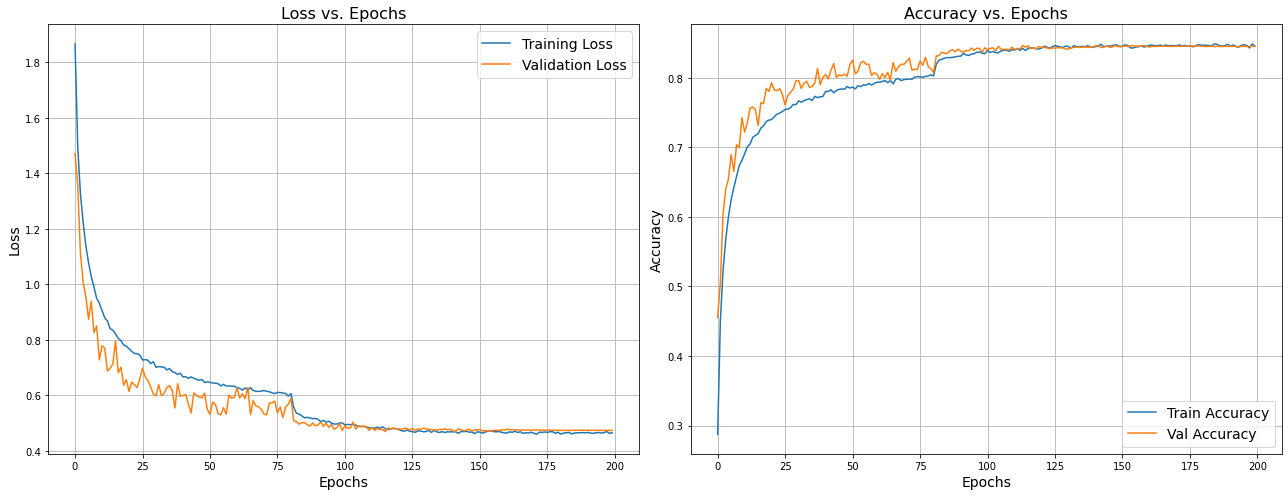

In [13]:
# Visualize the training process
train_loss = vgg_history.history['loss']
train_acc = vgg_history.history['acc']
val_loss = vgg_history.history['val_loss']
val_acc = vgg_history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
fig.savefig('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/result/vgg_loss.png', dpi=200)
plt.show()

In [14]:
# Load the saved model
vgg_model = keras.models.load_model('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/models/vgg_checkpoint.h5')

# Make predictions
test_pred = vgg_model.predict(test_x)
test_digit = np.argmax(test_pred, axis=1)
test_label = list(map(lambda x: digit2labels[x], test_digit))

idx = list(range(1, 300000 + 1))
df = pd.DataFrame({'id': idx, 'label': test_label})
df.to_csv('C:/Users/frodo/Desktop/stat578/CIFAR10/cifar-10/result/vgg_submission.csv', columns=['id', 'label'], index=False)